# ATLAS OmniFold - Stress Test C
In this notebook, we use two Monte Carlo Simulation samples to perform a stress test by treating one as simulation (synthetic data with both particle-level and detector-level information) and one as "data" (real collider data with only detector-level information). We unfold various distributions from "data" and compare it to the associated particle-level information because "data" is also a Monte Carlo simulation.

### Standard Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import absolute_import, division, print_function
import os
from ntupleanalysis import *
from omnifold import *

import numpy as np
import scipy.stats as stats
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing

In [3]:
### GPU Setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # pick a number between 0 & 3
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-09-23 11:15:41.984688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-09-23 11:15:42.020757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:c1:00.0 name: NVIDIA A40 computeCapability: 8.6
coreClock: 1.74GHz coreCount: 84 deviceMemorySize: 44.56GiB deviceMemoryBandwidth: 648.29GiB/s
2021-09-23 11:15:42.021253: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-09-23 11:15:42.022873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-23 11:15:42.024612: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-09-23 11:15:42.025093: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2021-0

In [4]:
plot_setup()

In [5]:
# Global plot settings
import matplotlib.font_manager

plt.rcParams.update({
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.family": "serif",
    "font.size": 22,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15
})

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'histtype': 'stepfilled', 'alpha': 0.5, 'density': True}

### Utilities

In [7]:
# z-score standardization of data

def standardize(sim_truth, sim_reco, data_reco, dummyval=-99):
    scaler_truth = preprocessing.StandardScaler()
    scaler_reco = preprocessing.StandardScaler()

    scaler_truth.fit(
        sim_truth[sim_truth != dummyval].astype(float).reshape(-1, 1))
    scaler_reco.fit(
        np.concatenate(
            (sim_reco[sim_reco != dummyval],
             data_reco[data_reco != dummyval])).astype(float).reshape(-1, 1))

    sim_truth_z = np.copy(sim_truth.astype(float))
    sim_reco_z = np.copy(sim_reco.astype(float))
    data_reco_z = np.copy(data_reco.astype(float))

    sim_truth_z[sim_truth != dummyval] = np.squeeze(
        scaler_truth.transform(
            sim_truth[sim_truth != dummyval].astype(float).reshape(-1, 1)))
    sim_reco_z[sim_reco != dummyval] = np.squeeze(
        scaler_reco.transform(
            sim_reco[sim_reco != dummyval].astype(float).reshape(-1, 1)))
    data_reco_z[data_reco != dummyval] = np.squeeze(
        scaler_reco.transform(
            data_reco[data_reco != dummyval].astype(float).reshape(-1, 1)))

    return sim_truth_z, sim_reco_z, data_reco_z

In [8]:
def get_uncertainty(data, weights, bins):
    sigma = np.empty(shape=((bins.size - 1), ))

    sum_weights = np.sum(weights)

    which_bin = np.digitize(data, bins)

    for i in range(sigma.size):
        sigma[i] = np.sqrt(np.sum(
            (weights[which_bin == (i + 1)])**2)) / sum_weights

    return sigma

In [9]:
def chi_square_dist(data_expected,
                    data_observed,
                    bins,
                    weights_expected=None,
                    weights_observed=None,
                    sigma_observed=None,
                    sigma_expected=None):

    if weights_expected is None:
        weights_expected = np.ones_like(data_expected)
    if weights_observed is None:
        weights_observed = np.ones_like(data_observed)

    H_expected, _ = np.histogram(data_expected,
                                 bins=bins,
                                 weights=weights_expected,
                                 density=True)

    H_observed, _ = np.histogram(data_observed,
                                 weights=weights_observed,
                                 bins=bins,
                                 density=True)

    if sigma_expected is None:
        sigma_expected = get_uncertainty(data_expected, weights_expected, bins)
    if sigma_observed is None:
        sigma_observed = get_uncertainty(data_observed, weights_observed, bins)

    uncertainty_squared = sigma_expected**2 + sigma_observed**2


    dist = (H_observed - H_expected)**2 / uncertainty_squared
    dist[np.isnan(dist)] = 0
    dist = np.sum(dist)

    return dist

In [10]:
def best_1D_reweighting(test,
                        target,
                        bins,
                        test_weights=None,
                        target_weights=None):

    dists = []
    for i in range(len(test_weights)):
        dists += [
            chi_square_dist(data_expected=target,
                            weights_expected=target_weights,
                            data_observed=test,
                            weights_observed=test_weights[i],
                            bins=bins)
        ]
    
    return test_weights[np.argmin(dists)]

In [11]:
def best_nD_reweighting(test,
                        target,
                        bins,
                        test_weights=None,
                        nominal_weights=None,
                        target_weights=None):

    dists_nominal = np.empty(shape=(len(test), len(test_weights)))
    dists_rewgt = np.empty(shape=(len(test), len(test_weights)))

    for i in range(dists_nominal.shape[0]):
        dists_nominal[i, :] = chi_square_dist(data_expected=target[i],
                                              weights_expected=target_weights,
                                              data_observed=test[i],
                                              weights_observed=nominal_weights,
                                              bins=bins[i])

        for j in range(dists_nominal.shape[1]):
            dists_rewgt[i, j] = chi_square_dist(data_expected=target[i],
                                                weights_expected=target_weights,
                                                data_observed=test[i],
                                                weights_observed=test_weights[j],
                                                bins=bins[i])

    rewgt_score = np.mean(dists_rewgt / dists_nominal, axis=0)

    return test_weights[np.argmin(rewgt_score)]

In [12]:
plot_dir = './SupportNote/figures/ATLASOmniFold-StressTest/ATLASOmniFold-StressTestC/'

In [13]:
save_label0 = 'ATLASOmniFold-StressTestC'

### Load ROOT files

#### Simulation (Powheg + Pythia 8 MC16e)

In [14]:
data_dir = '/clusterfs/ml4hep/adisurtya/ATLASOmniFold/slimmedSamples/'

In [15]:
Events_sim = uproot.lazy(
    data_dir +
    "ZjetOmnifold_Jun25_PowhegPythia_mc16e_slim.root:OmniTree"
)

In [16]:
for field in Events_sim.fields:
    print(field)

weight
pass190
truth_pass190
weight_mc
prw
pT_ll
pT_l1
pT_l2
eta_l1
eta_l2
phi_l1
phi_l2
y_ll
pT_trackj1
y_trackj1
phi_trackj1
m_trackj1
tau1_trackj1
tau2_trackj1
tau3_trackj1
pT_trackj2
y_trackj2
phi_trackj2
m_trackj2
tau1_trackj2
tau2_trackj2
tau3_trackj2
truth_pT_ll
truth_pT_l1
truth_pT_l2
truth_eta_l1
truth_eta_l2
truth_phi_l1
truth_phi_l2
truth_y_ll
truth_pT_trackj1
truth_y_trackj1
truth_phi_trackj1
truth_m_trackj1
truth_tau1_trackj1
truth_tau2_trackj1
truth_tau3_trackj1
truth_pT_trackj2
truth_y_trackj2
truth_phi_trackj2
truth_m_trackj2
truth_tau1_trackj2
truth_tau2_trackj2
truth_tau3_trackj2
EventNumber
RunNumber
Ntracks
Ntracks_trackj1
Ntracks_trackj2
truth_Ntracks
truth_Ntracks_trackj1
truth_Ntracks_trackj2
pT_tracks
eta_tracks
phi_tracks
trackJetIndex_tracks
truth_pT_tracks
truth_eta_tracks
truth_phi_tracks
truth_trackJetIndex_tracks


#### "Data" (Sherpa 2.2.1 MC16e)

In [17]:
Events_data = uproot.lazy(data_dir +
                          "ZjetOmnifold_Jun25_Sherpa221_mc16e_slim.root:OmniTree")

In [18]:
for field in Events_data.fields:
    print(field)

weight
pass190
truth_pass190
weight_mc
prw
pT_ll
pT_l1
pT_l2
eta_l1
eta_l2
phi_l1
phi_l2
y_ll
pT_trackj1
y_trackj1
phi_trackj1
m_trackj1
tau1_trackj1
tau2_trackj1
tau3_trackj1
pT_trackj2
y_trackj2
phi_trackj2
m_trackj2
tau1_trackj2
tau2_trackj2
tau3_trackj2
truth_pT_ll
truth_pT_l1
truth_pT_l2
truth_eta_l1
truth_eta_l2
truth_phi_l1
truth_phi_l2
truth_y_ll
truth_pT_trackj1
truth_y_trackj1
truth_phi_trackj1
truth_m_trackj1
truth_tau1_trackj1
truth_tau2_trackj1
truth_tau3_trackj1
truth_pT_trackj2
truth_y_trackj2
truth_phi_trackj2
truth_m_trackj2
truth_tau1_trackj2
truth_tau2_trackj2
truth_tau3_trackj2
EventNumber
RunNumber
Ntracks
Ntracks_trackj1
Ntracks_trackj2
truth_Ntracks
truth_Ntracks_trackj1
truth_Ntracks_trackj2
pT_tracks
eta_tracks
phi_tracks
trackJetIndex_tracks
truth_pT_tracks
truth_eta_tracks
truth_phi_tracks
truth_trackJetIndex_tracks


### Unpack data

In [19]:
# Event selection

mypass_sim = (Events_sim['pass190'].to_numpy().astype(bool)) | (
    Events_sim['truth_pass190'].to_numpy().astype(bool))
mycut_sim_truth = np.invert(
    Events_sim['truth_pass190'].to_numpy().astype(bool))[mypass_sim]
mycut_sim_reco = np.invert(
    Events_sim['pass190'].to_numpy().astype(bool))[mypass_sim]

mypass_data_truth = Events_data['truth_pass190'].to_numpy().astype(bool)
mypass_data_reco = Events_data['pass190'].to_numpy().astype(bool)

dummyval = -99

In [20]:
# Load Monte Carlo Event Weights
sim_truth_weights_MC = np.array(Events_sim['weight_mc'][mypass_sim].to_list())
sim_reco_weights_MC = np.array(Events_sim['weight'][mypass_sim].to_list())

data_truth_weights_MC = np.array(
    Events_data['weight_mc'][mypass_data_truth].to_list())
data_reco_weights_MC = np.array(
    Events_data['weight'][mypass_data_reco].to_list())

# standardize
sim_truth_weights_MC /= np.mean(sim_truth_weights_MC)
sim_reco_weights_MC /= np.mean(sim_reco_weights_MC)

data_truth_weights_MC /= np.mean(data_truth_weights_MC)
data_reco_weights_MC /= np.mean(data_reco_weights_MC)

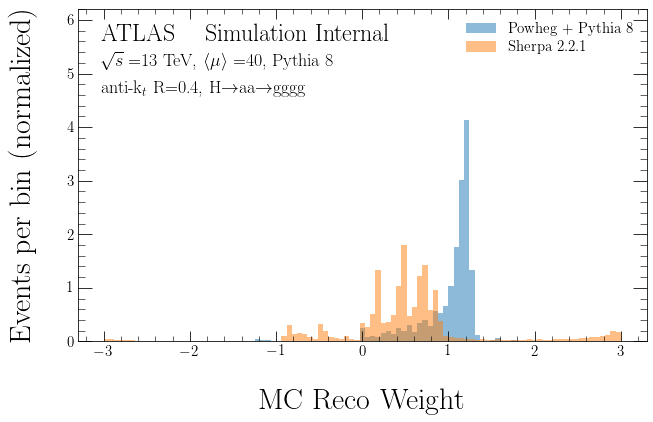

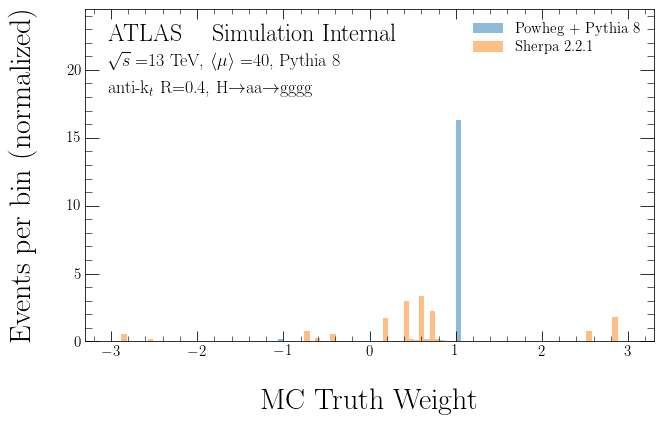

In [21]:
bins = np.linspace(-3, 3, 100)

plt.figure(figsize=(10, 6))
hW_sim_reco, _, _ = plt.hist(sim_reco_weights_MC,
                             bins=bins,
                             label=r'Powheg + Pythia 8',
                             **plot_style_2)
hW_data_reco, _, _ = plt.hist(data_reco_weights_MC,
                              bins=bins,
                              label=r'Sherpa 2.2.1',
                              **plot_style_2)
plt.xlabel('MC Reco Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_reco, hW_data_reco)))
plt.legend()
draw_atlas_text()
plt.show()


plt.figure(figsize=(10, 6))
hW_sim_truth, _, _ = plt.hist(sim_truth_weights_MC,
                              bins=bins,
                              label=r'Powheg + Pythia 8',
                              **plot_style_2)
hW_data_truth, _, _ = plt.hist(data_truth_weights_MC,
                               bins=bins,
                               label=r'Sherpa 2.2.1',
                               **plot_style_2)
plt.xlabel('MC Truth Weight')
plt.ylabel('Events per bin (normalized)')
plt.ylim(top=1.5 * np.max((hW_sim_truth, hW_data_truth)))
plt.legend()
draw_atlas_text()
plt.show()

In [22]:
file_labels = [
    'Ntracks_trackj1', 'Ntracks_trackj2', 'm_trackj1', 'm_trackj2',
    'pT_trackj1', 'pT_trackj2', 'y_trackj1', 'y_trackj2', 'phi_trackj1',
    'phi_trackj2', 'tau1_trackj1', 'tau1_trackj2', 'tau2_trackj1',
    'tau2_trackj2', 'tau3_trackj1', 'tau3_trackj2', 'pT_ll', 'y_ll', 'pT_l1',
    'pT_l2', 'eta_l1', 'eta_l2', 'phi_l1', 'phi_l2'
]

plot_labels = [
    r'Leading track jet $n_{\textrm{ch}}$ ',
    r'Subleading track jet $n_{\textrm{ch}}$', 'Leading track jet $m$ [GeV]',
    r'Subleading track jet $m$ [GeV]', r'Leading track jet $p_T$ [GeV]',
    r'Subleading track jet $p_T$ [GeV]', r'Leading track jet $y$',
    r'Subleading track jet $y$', r'Leading track jet $\phi$',
    r'Subleading track jet $\phi$', r'Leading track jet $\tau_1$',
    r'Subleading track jet $\tau_1$', r'Leading track jet $\tau_2$',
    r'Subleading track jet $\tau_2$', r'Leading track jet $\tau_3$',
    r'Subleading track jet $\tau_3$', r'$p^{\mu \mu}_T$ [GeV]',
    r'$y_{\mu \mu}$', r'$p^{\mu 1}_{T}$ [GeV]', r'$p^{\mu 2}_{T}$ [GeV]',
    '$\eta_{\mu 1}$', '$\eta_{\mu 2}$', '$\phi_{\mu 1}$', '$\phi_{\mu 2}$'
]

In [23]:
IBU_hists = uproot.open('/clusterfs/ml4hep/adisurtya/ATLASOmniFold/unfoldingPlotsJune14_UnfoldedHists.root')
for key in IBU_hists.keys():
    print(key)

SherpaUnfoldWPythia_2016_pT_ll;1
SherpaUnfoldWPythia_2016_y_ll;1
SherpaUnfoldWPythia_2016_m_ll;1
SherpaUnfoldWPythia_2016_pT_l1;1
SherpaUnfoldWPythia_2016_pT_l2;1
SherpaUnfoldWPythia_2016_eta_l1;1
SherpaUnfoldWPythia_2016_eta_l2;1
SherpaUnfoldWPythia_2016_phi_l1;1
SherpaUnfoldWPythia_2016_phi_l2;1
SherpaUnfoldWPythia_2016_pT_trackj1;1
SherpaUnfoldWPythia_2016_y_trackj1;1
SherpaUnfoldWPythia_2016_phi_trackj1;1
SherpaUnfoldWPythia_2016_m_trackj1;1
SherpaUnfoldWPythia_2016_tau1_trackj1;1
SherpaUnfoldWPythia_2016_tau2_trackj1;1
SherpaUnfoldWPythia_2016_tau3_trackj1;1
SherpaUnfoldWPythia_2016_pT_trackj2;1
SherpaUnfoldWPythia_2016_y_trackj2;1
SherpaUnfoldWPythia_2016_phi_trackj2;1
SherpaUnfoldWPythia_2016_m_trackj2;1
SherpaUnfoldWPythia_2016_tau1_trackj2;1
SherpaUnfoldWPythia_2016_tau2_trackj2;1
SherpaUnfoldWPythia_2016_tau3_trackj2;1
SherpaUnfoldWPythia_2016_Ntracks_trackj1;1
SherpaUnfoldWPythia_2016_Ntracks_trackj2;1
SherpaUnfoldWPythia_2017_pT_ll;1
SherpaUnfoldWPythia_2017_y_ll;1
SherpaUn

In [24]:
bins = []
for label in file_labels:
    bins += [IBU_hists['SherpaUnfoldWPythia_2018_'+label].to_numpy()[1]]

In [25]:
labels_and_bins = zip(file_labels, plot_labels, bins)

obs = []

for file_label, plot_label, plot_bins in labels_and_bins:
    obs += [{
        'file_label': file_label,
        'plot_label': plot_label,
        'bins': plot_bins
    }]

In [26]:
# # Preview Observables

# fig, ax = plt.subplots(6, 4, figsize=(40, 36), constrained_layout=True)
# ax = np.ndarray.flatten(ax)

# for i in range(len(obs)):
#     bins = obs[i]['bins']
#     hT, _, _ = ax[i].hist(
#         Events_sim['truth_' + obs[i]['file_label']][
#             Events_sim['truth_pass190'].to_numpy().astype(bool)],
#         weights=Events_sim['weight_mc'][
#             Events_sim['truth_pass190'].to_numpy().astype(bool)],
#         bins=bins,
#         label="MC Truth",
#         **plot_style_2)
#     hR, _, _ = ax[i].hist(Events_sim[obs[i]['file_label']][
#         Events_sim['pass190'].to_numpy().astype(bool)],
#                           weights=Events_sim['weight'][
#                               Events_sim['pass190'].to_numpy().astype(bool)],
#                           bins=bins,
#                           label="MC Reco",
#                           **plot_style_2)
#     ax[i].set_xlabel(obs[i]['plot_label'])
#     draw_atlas_text(ax=ax[i])
#     if i % 4 == 0:
#         ax[i].set_ylabel("Events per bin (normalized)")
#     ax[i].legend()
#     ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

In [27]:
# # Preview Observables

# fig, ax = plt.subplots(6, 4, figsize=(40, 36), constrained_layout=True)
# ax = np.ndarray.flatten(ax)

# for i in range(len(obs)):
#     bins = obs[i]['bins']
#     hT, _, _ = ax[i].hist(
#         Events_sim['truth_' + obs[i]['file_label']][
#             Events_sim['truth_pass190'].to_numpy().astype(bool)],
#         weights=Events_sim['weight_mc'][
#             Events_sim['truth_pass190'].to_numpy().astype(bool)],
#         bins=bins,
#         label="MC Truth",
#         color='C2',
#         **plot_style_2)
#     hR, _, _ = ax[i].hist(Events_sim[obs[i]['file_label']][
#         Events_sim['pass190'].to_numpy().astype(bool)],
#                           weights=Events_sim['weight'][
#                               Events_sim['pass190'].to_numpy().astype(bool)],
#                           bins=bins,
#                           label="MC Reco",
#                           color='k',
#                           **plot_style_2)
#     ax[i].set_xlabel(obs[i]['plot_label'])
#     draw_atlas_text(ax=ax[i])
#     if i % 4 == 0:
#         ax[i].set_ylabel("Events per bin (normalized)")
#     ax[i].legend()
#     ax[i].set_ylim([0, 1.5 * max(max(hT), max(hR))])

# UniFold

To show unfolding of individual observables ("UniFold"), we will unfold the following observables for the leading track jet: the jet mass $m_{j_1}$, the number of constituents (tracks) $N_{j_1}$, the transverse momentum $p_{T,j_1}$, the rapidity $y_{j_1}$, and the $n$-subjettiness $\tau_{1, j_1}$.

In [28]:
selected_leading_jet_obs_index = [0, 2, 4, 6, 10]

In [29]:
unifold_weights = np.zeros(shape=(len(obs), len(sim_truth_weights_MC)))

In [30]:
unifold_weights.shape

(24, 416725)

## Unfold $N_{j_1}$

In [31]:
K.clear_session()

In [32]:
obs_index = selected_leading_jet_obs_index[0]  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [33]:
sim_truth = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
sim_truth[mycut_sim_truth] = dummyval
sim_reco = np.array(Events_sim[file_label][mypass_sim].to_list())
sim_reco[mycut_sim_reco] = dummyval

data_truth = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
data_reco = np.array(Events_data[file_label][mypass_data_reco].to_list())

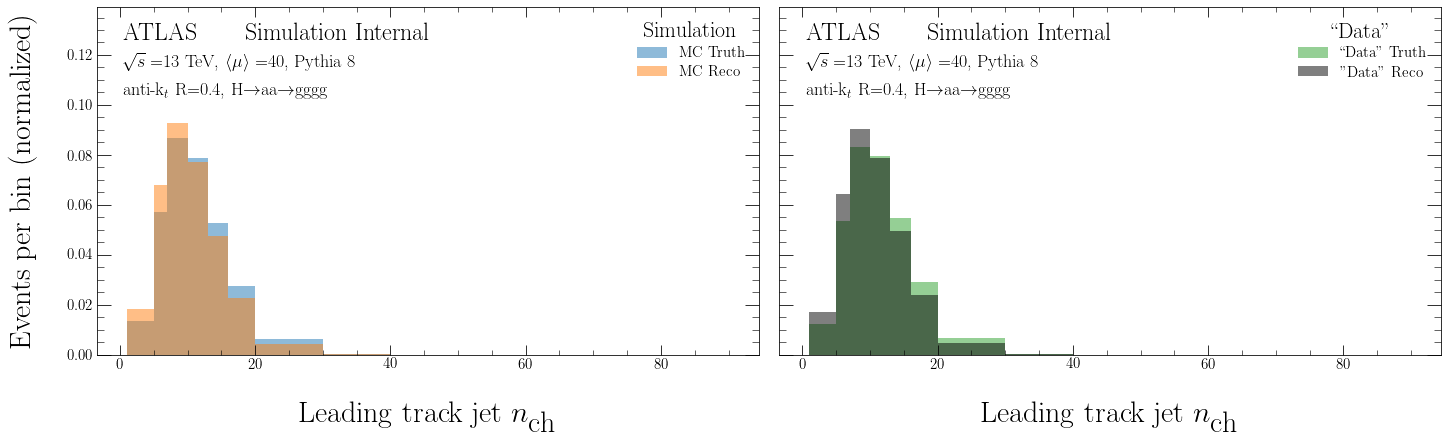

In [36]:
plot_distributions(
    sim_truth=sim_truth,
    sim_reco=sim_reco,
    sim_truth_weights_MC=sim_truth_weights_MC,
    sim_reco_weights_MC=sim_reco_weights_MC,
    data_truth=data_truth,
    data_reco=data_reco,
    data_truth_weights_MC=data_truth_weights_MC,
    data_reco_weights_MC=data_reco_weights_MC,
    bins=bins,
    x_label=x_label,
    save_label=save_label)

### Unfold 

In [37]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [38]:
weights, _ = unifold(iterations=3,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)

unifold_weights[obs_index] = best_1D_reweighting(
    test=sim_reco,
    test_weights=sim_reco_weights_MC * weights[:, 1],
    target=data_reco,
    target_weights=data_reco_weights_MC,
    bins=bins)

2021-09-23 11:17:39.465067: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2021-09-23 11:17:39.476307: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2994305000 Hz
2021-09-23 11:17:39.478359: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d8462400a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-23 11:17:39.478408: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-09-23 11:17:39.548684: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55d842920880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-09-23 11:17:39.548739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2021-09-23 11:17:39.551216: I tenso


ITERATION: 1

STEP 1

Epoch 1/1000


2021-09-23 11:19:46.403398: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


245/245 [==============================] - 1s 4ms/step - loss: 0.3667 - accuracy: 0.4473 - val_loss: 0.3376 - val_accuracy: 0.4471
Epoch 2/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.4473 - val_loss: 0.3375 - val_accuracy: 0.4471
Epoch 3/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.4473 - val_loss: 0.3375 - val_accuracy: 0.4471
Epoch 4/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.4473 - val_loss: 0.3376 - val_accuracy: 0.4471
Epoch 5/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3371 - accuracy: 0.4473 - val_loss: 0.3375 - val_accuracy: 0.4471
Epoch 6/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.4473 - val_loss: 0.3377 - val_accuracy: 0.4471
Epoch 7/1000
245/245 [==============================] - 1s 3ms/step - loss: 0.3371 - accuracy: 0.4473 - val_loss: 0.3375 - val_accuracy: 0.4471
Epoch

/clusterfs/ml4hep/mpettee/ATLASOmniFold/omnifold/unifold.py:16: RuntimeWarning: divide by zero encountered in true_divide
  weights = f / (1. - f)



STEP 1b

Epoch 1/1000
49/49 [==============================] - 0s 4ms/step - loss: 1.5939 - accuracy: 0.2500 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 2/1000
49/49 [==============================] - 0s 5ms/step - loss: 1.5937 - accuracy: 0.2500 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 3/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5937 - accuracy: 0.2500 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 4/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5937 - accuracy: 0.2500 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 5/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5938 - accuracy: 0.2500 - val_loss: 1.5956 - val_accuracy: 0.2500
Epoch 6/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5938 - accuracy: 0.2500 - val_loss: 1.5954 - val_accuracy: 0.2500
Epoch 7/1000
49/49 [==============================] - 0s 3ms/step - loss: 1.5939 - accuracy: 0.2500 - val_loss: 1.5955 - val_accuracy: 0.2

In [39]:
weights.shape

(3, 2, 416725)

In [40]:
weights[:,1].shape

(3, 416725)

In [41]:
sim_reco_weights_MC.shape

(416725,)

In [45]:
(sim_reco_weights_MC * weights[:, 1]).shape

(3, 416725)

#### Results

ITERATION 1:
ITERATION 2:
ITERATION 3:


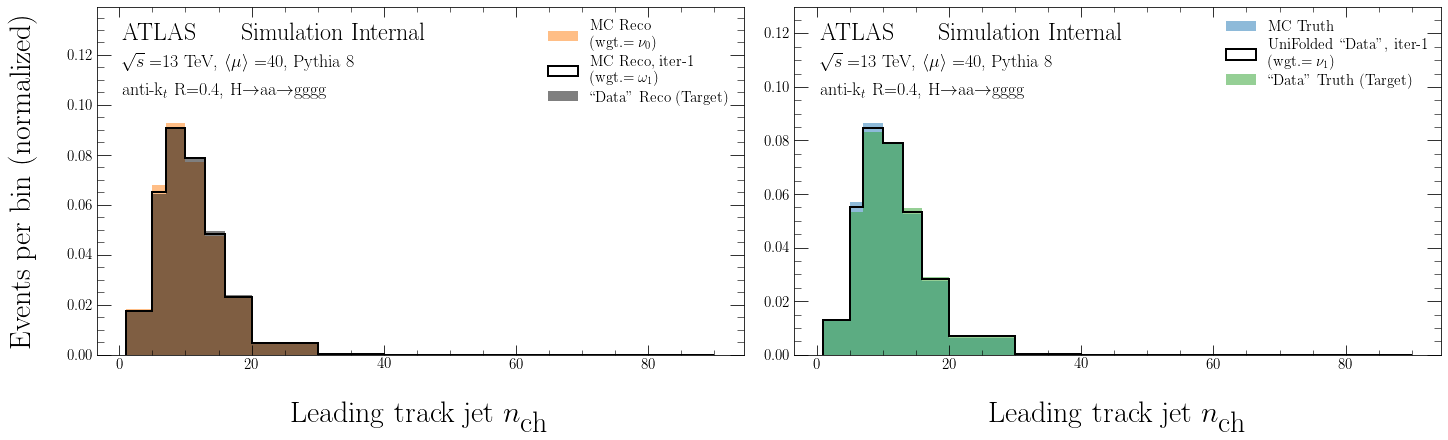

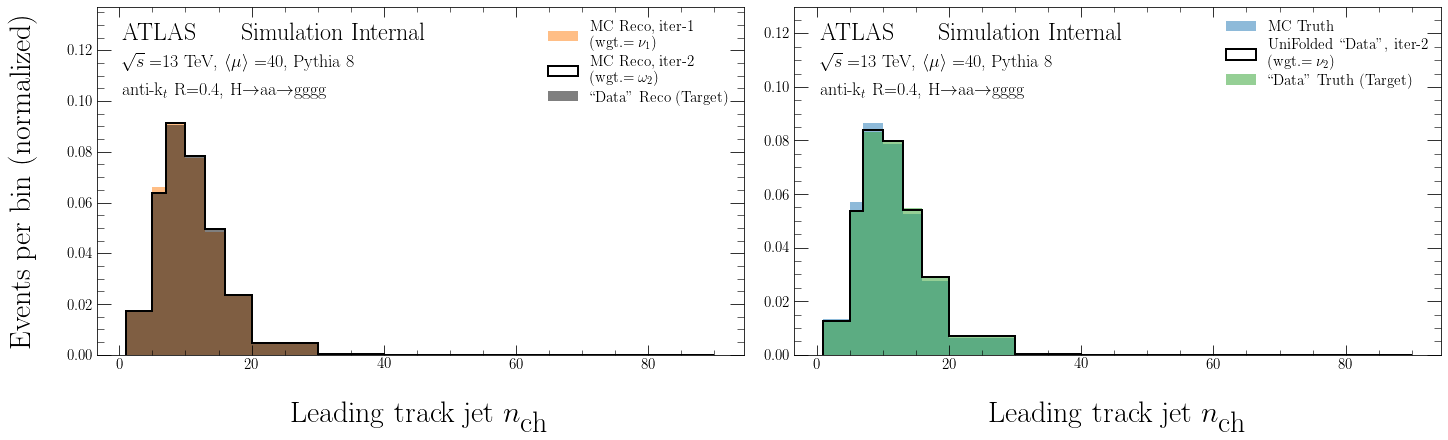

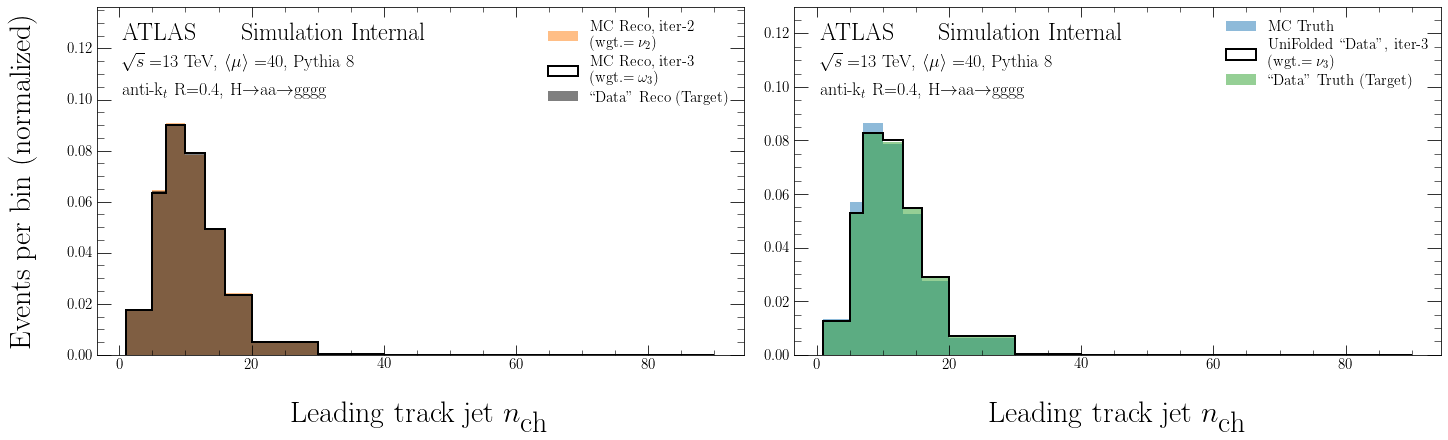

In [47]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label)

## Unfold $m_{j_1}$

In [ ]:
K.clear_session()

In [ ]:
obs_index = selected_leading_jet_obs_index[1]  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [ ]:
sim_truth = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
sim_truth[mycut_sim_truth] = dummyval
sim_reco = np.array(Events_sim[file_label][mypass_sim].to_list())
sim_reco[mycut_sim_reco] = dummyval

data_truth = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
data_reco = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [ ]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [ ]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)

unifold_weights[obs_index] = best_1D_reweighting(
    test=sim_reco,
    test_weights=sim_reco_weights_MC * weights[:, 1],
    target=data_reco,
    target_weights=data_reco_weights_MC,
    bins=bins)

#### Results

In [ ]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label)

## Unfold $p_{T, j_1}$

In [ ]:
K.clear_session()

In [ ]:
obs_index = selected_leading_jet_obs_index[2]  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [ ]:
sim_truth = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
sim_truth[mycut_sim_truth] = dummyval
sim_reco = np.array(Events_sim[file_label][mypass_sim].to_list())
sim_reco[mycut_sim_reco] = dummyval

data_truth = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
data_reco = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [ ]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [ ]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)

unifold_weights[obs_index] = best_1D_reweighting(
    test=sim_reco,
    test_weights=sim_reco_weights_MC * weights[:, 1],
    target=data_reco,
    target_weights=data_reco_weights_MC,
    bins=bins)

#### Results

In [ ]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label)

## Unfold $y_{j_1}$

In [ ]:
K.clear_session()

In [ ]:
obs_index = selected_leading_jet_obs_index[3]  # index for this observable

bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [ ]:
sim_truth = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
sim_truth[mycut_sim_truth] = dummyval
sim_reco = np.array(Events_sim[file_label][mypass_sim].to_list())
sim_reco[mycut_sim_reco] = dummyval

data_truth = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
data_reco = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [ ]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [ ]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)

unifold_weights[obs_index] = best_1D_reweighting(
    test=sim_reco,
    test_weights=sim_reco_weights_MC * weights[:, 1],
    target=data_reco,
    target_weights=data_reco_weights_MC,
    bins=bins)

#### Results

In [ ]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label)

## Unfold $\tau _{j_1}$

In [ ]:
K.clear_session()

In [ ]:
obs_index = selected_leading_jet_obs_index[4]  # index for this observable
bins = obs[obs_index]['bins']
x_label = obs[obs_index]['plot_label']
file_label = obs[obs_index]['file_label']
save_label = plot_dir + 'UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

### Setup Datasets

In [ ]:
sim_truth = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
sim_truth[mycut_sim_truth] = dummyval
sim_reco = np.array(Events_sim[file_label][mypass_sim].to_list())
sim_reco[mycut_sim_reco] = dummyval

data_truth = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
data_reco = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
plot_distributions(sim_truth=sim_truth,
                   sim_reco=sim_reco,
                   sim_truth_weights_MC=sim_truth_weights_MC,
                   sim_reco_weights_MC=sim_reco_weights_MC,
                   data_truth=data_truth,
                   data_reco=data_reco,
                   data_truth_weights_MC=data_truth_weights_MC,
                   data_reco_weights_MC=data_reco_weights_MC,
                   bins=bins,
                   x_label=x_label,
                   save_label=save_label)

### Unfold 

In [ ]:
# z-score standardization of data

sim_truth_z, sim_reco_z, data_reco_z = standardize(sim_truth, sim_reco,
                                                   data_reco)

In [ ]:
weights, _ = unifold(iterations=10,
                     sim_truth=sim_truth_z,
                     sim_reco=sim_reco_z,
                     sim_truth_weights_MC=sim_truth_weights_MC,
                     sim_reco_weights_MC=sim_reco_weights_MC,
                     data_reco=data_reco_z,
                     data_reco_weights_MC=data_reco_weights_MC,
                     dummyval=dummyval,
                     verbose=1)

unifold_weights[obs_index] = best_1D_reweighting(
    test=sim_reco,
    test_weights=sim_reco_weights_MC * weights[:, 1],
    target=data_reco,
    target_weights=data_reco_weights_MC,
    bins=bins)

#### Results

In [ ]:
plot_results(sim_truth=sim_truth,
             sim_reco=sim_reco,
             sim_truth_weights_MC=sim_truth_weights_MC,
             sim_reco_weights_MC=sim_reco_weights_MC,
             data_truth=data_truth,
             data_reco=data_reco,
             data_truth_weights_MC=data_truth_weights_MC,
             data_reco_weights_MC=data_reco_weights_MC,
             weights=weights,
             bins=bins,
             x_label=x_label,
             flavor_label='UniFold',
             save_label=save_label)

## Unfold other observables

### Setup datasets

In [ ]:
sim_truth = [None] * len(obs)
sim_reco = [None] * len(obs)
data_truth = [None] * len(obs)
data_reco = [None] * len(obs)

In [ ]:
for i in range(len(obs)):
    file_label = obs[i]['file_label']

    sim_truth[i] = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
    sim_truth[i][mycut_sim_truth] = dummyval
    sim_reco[i] = np.array(Events_sim[file_label][mypass_sim].to_list())
    sim_reco[i][mycut_sim_reco] = dummyval
    data_truth[i] = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
    data_reco[i] = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
for i in range(len(obs)):
    # check if we already unfoled the observable
    if i in selected_leading_jet_obs_index:
        continue

    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label
    plot_distributions(sim_truth=sim_truth[i],
                       sim_reco=sim_reco[i],
                       sim_truth_weights_MC=sim_truth_weights_MC,
                       sim_reco_weights_MC=sim_reco_weights_MC,
                       data_truth=data_truth[i],
                       data_reco=data_reco[i],
                       data_truth_weights_MC=data_truth_weights_MC,
                       data_reco_weights_MC=data_reco_weights_MC,
                       bins=bins,
                       x_label=x_label,
                       save_label=save_label)

### Unfold 

In [ ]:
# z-score standardization of data
sim_truth_z = [None] * len(obs)
sim_reco_z = [None] * len(obs)
data_reco_z = [None] * len(obs)

for i in range(len(obs)):
    # check if we already unfoled the observable
    if i in selected_leading_jet_obs_index:
        continue

    sim_truth_z[i], sim_reco_z[i], data_reco_z[i] = standardize(
        sim_truth[i], sim_reco[i], data_reco[i])

In [ ]:
iterations = 10
weights = np.zeros(shape=(len(obs), iterations, 2, len(sim_truth_weights_MC)))

for i in range(len(obs)):
    # check if we already unfoled the observable
    if i in selected_leading_jet_obs_index:
        continue

    K.clear_session()
    weights[i], _ = unifold(iterations=iterations,
                            sim_truth=sim_truth_z[i],
                            sim_reco=sim_reco_z[i],
                            sim_truth_weights_MC=sim_truth_weights_MC,
                            sim_reco_weights_MC=sim_reco_weights_MC,
                            data_reco=data_reco_z[i],
                            data_reco_weights_MC=data_reco_weights_MC,
                            dummyval=dummyval,
                            verbose=0)

    unifold_weights[i] = best_1D_reweighting(
        test=sim_reco[i],
        test_weights=sim_reco_weights_MC * weights[i, :, 1],
        target=data_reco[i],
        target_weights=data_reco_weights_MC,
        bins=bins)

#### Results

In [ ]:
for i in range(len(obs)):
    # check if we already unfoled the observable
    if i in selected_leading_jet_obs_index:
        continue

    print(obs[i]['file_label'] + " Results\n")
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/UniFold/' + file_label + '/' + save_label0 + '-UniFold-' + file_label

    plot_results(sim_truth=sim_truth[i],
                 sim_reco=sim_reco[i],
                 sim_truth_weights_MC=sim_truth_weights_MC,
                 sim_reco_weights_MC=sim_reco_weights_MC,
                 data_truth=data_truth[i],
                 data_reco=data_reco[i],
                 data_truth_weights_MC=data_truth_weights_MC,
                 data_reco_weights_MC=data_reco_weights_MC,
                 weights=weights[i],
                 bins=bins,
                 x_label=x_label,
                 flavor_label='UniFold',
                 save_label=save_label)

## Comparison to IBU

In [ ]:
unifold_dist = []
IBU_dist = []
# file = PdfPages("UniFold_vs_IBU_May27.pdf")
for i in range(len(obs)):
    bins = obs[i]['bins']
    
    fig = plt.figure(figsize=(10, 6))
    h1, _, _ = plt.hist(data_truth[i],
                        bins=bins,
                        weights=data_truth_weights_MC,
                        label='"Data" Truth (Target)',
                        **plot_style_2)
    h2, _, _ = plt.hist(sim_truth[i],
                        bins=bins,
                        weights=sim_truth_weights_MC * unifold_weights[i],
                        label='UniFold',
                        **plot_style_0)
    unifold_dist += [
        chi_square_dist(data_expected=data_truth[i],
                        data_observed=sim_truth[i],
                        bins=bins,
                        weights_expected=data_truth_weights_MC,
                        weights_observed=sim_truth_weights_MC *
                        unifold_weights[i])
    ]

    IBU_hist = IBU_hists['SherpaUnfoldWPythia_2018_' + obs[i]['file_label']]
    h3, _, _ = plt.hist(bins[:-1],
                        bins=bins,
                        weights=IBU_hist.to_numpy()[0],
                        label='IBU',
                        **plot_style_1)

    IBU_dist += [
        chi_square_dist(data_expected=data_truth[i],
                        data_observed=bins[:-1],
                        bins=bins,
                        weights_expected=data_truth_weights_MC,
                        weights_observed=IBU_hist.to_numpy()[0],
                        sigma_observed=IBU_hist.errors() /
                        sum(IBU_hist.to_numpy()[0])),
    ]

    plt.xlabel(obs[i]['plot_label'])
    plt.ylabel("Events per bin (normalized)")
    plt.ylim([0, 1.5 * np.max(np.concatenate((h1, h2, h3)))])
    draw_atlas_text()
    plt.legend()
    plt.show()
#     file.savefig(fig, bbox_inches='tight')

# file.close()

In [ ]:
print(
    "Chi-square distance comparison between UniFold and IBU for each observable\n "
)
print("Observable           UniFold      IBU")
print("________________________________________\n")
for i in range(len(obs)):
    print("{:20} {:.1e}     {:.1e}".format(file_labels[i], unifold_dist[i],
                                           IBU_dist[i]))
    print("")

# MultiFold

To show unfolding of multiple observables simultaneously ("MultiFold"), we will unfold the following observables together: the leading jet number of constituents (tracks) $N_{j_1}$, the leading jet mass $m_{j_1}$,  the leading jet transverse momentum $p_{T,j_1}$, the leading jet rapidity $y_{j_1}$, the leading jet azimuthal angle $\phi_{j_1}$, the leading jet $n$-subjettiness ($\tau_{1, j_1}$, $\tau_{2, j_1}$, $\tau_{3, j_1}$), the subleading jet number of constituents (tracks) $N_{j_2}$, the subleading jet mass $m_{j_2}$,  the subleading jet transverse momentum $p_{T,j_2}$, the subleading jet rapidity $y_{j_2}$, the subleading jet azimuthal angle $\phi_{j_2}$, the subleading jet $n$-subjettiness ($\tau_{1, j_2}$, $\tau_{2, j_2}$, $\tau_{3, j_2}$), the dilepton transverse momentum $p_{T,ll}$, the dilepton rapidity $y_{ll}$, the leading lepton transverse momentum $p_{T,l_1}$, the leading lepton pseudorapidity $\eta_{l_1}$, the leading lepton azimuthal angle $\phi_{l_1}$, the subleading lepton transverse momentum $p_{T,l_2}$, the subleading lepton pseudorapidity $\eta_{l_2}$, and the subleading lepton azimuthal angle $\phi_{l_2}$ for a total of **24 observables**.

In [ ]:
K.clear_session()

## Setup datasets

In [ ]:
sim_truth = [None] * len(obs)
sim_reco = [None] * len(obs)
data_truth = [None] * len(obs)
data_reco = [None] * len(obs)

In [ ]:
for i in range(len(obs)):
    file_label = obs[i]['file_label']

    sim_truth[i] = np.array(Events_sim['truth_' + file_label][mypass_sim].to_list())
    sim_truth[i][mycut_sim_truth] = dummyval
    sim_reco[i] = np.array(Events_sim[file_label][mypass_sim].to_list())
    sim_reco[i][mycut_sim_reco] = dummyval
    data_truth[i] = np.array(Events_data['truth_' + file_label][mypass_data_truth].to_list())
    data_reco[i] = np.array(Events_data[file_label][mypass_data_reco].to_list())

In [ ]:
for i in range(len(obs)):
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label
    plot_distributions(sim_truth=sim_truth[i],
                       sim_reco=sim_reco[i],
                       sim_truth_weights_MC=sim_truth_weights_MC,
                       sim_reco_weights_MC=sim_reco_weights_MC,
                       data_truth=data_truth[i],
                       data_reco=data_reco[i],
                       data_truth_weights_MC=data_truth_weights_MC,
                       data_reco_weights_MC=data_reco_weights_MC,
                       bins=bins,
                       x_label=x_label,
                       save_label=save_label)

## Unfold 

In [ ]:
# z-score standardization of data
sim_truth_z = [None] * len(obs)
sim_reco_z = [None] * len(obs)
data_reco_z = [None] * len(obs)

for i in range(len(obs)):
    sim_truth_z[i], sim_reco_z[i], data_reco_z[i] = standardize(
        sim_truth[i], sim_reco[i], data_reco[i])

In [ ]:
weights, _ = multifold(iterations=10,
                       sim_truth=sim_truth_z,
                       sim_reco=sim_reco_z,
                       sim_truth_weights_MC=sim_truth_weights_MC,
                       sim_reco_weights_MC=sim_reco_weights_MC,
                       data_reco=data_reco_z,
                       data_reco_weights_MC=data_reco_weights_MC,
                       dummyval=dummyval,
                       verbose=1)

bins = [obs[i]['bins'] for i in range(len(obs))]
multifold_weights = best_nD_reweighting(test=sim_reco,
                                        target=data_reco,
                                        bins=bins,
                                        test_weights=weights[:, 1] *
                                        sim_reco_weights_MC,
                                        nominal_weights=sim_reco_weights_MC,
                                        target_weights=data_reco_weights_MC)

#### Results

In [ ]:
for i in range(len(obs)):
    print(obs[i]['file_label'] + " Results\n")
    bins = obs[i]['bins']
    x_label = obs[i]['plot_label']
    file_label = obs[i]['file_label']
    save_label = plot_dir + '/MultiFold/' + file_label + '/' + save_label0 + '-MultiFold-' + file_label

    plot_results(sim_truth=sim_truth[i],
                 sim_reco=sim_reco[i],
                 sim_truth_weights_MC=sim_truth_weights_MC,
                 sim_reco_weights_MC=sim_reco_weights_MC,
                 data_truth=data_truth[i],
                 data_reco=data_reco[i],
                 data_truth_weights_MC=data_truth_weights_MC,
                 data_reco_weights_MC=data_reco_weights_MC,
                 weights=weights,
                 bins=bins,
                 x_label=x_label,
                 flavor_label='MultiFold',
                 save_label=save_label)

## Comparison to IBU

In [ ]:
multifold_dist = []
IBU_dist = []
#file = PdfPages("MultiFold_vs_IBU_May27.pdf")
for i in range(len(obs)):
    bins = obs[i]['bins']

    fig = plt.figure(figsize=(10, 6))
    h1, _, _ = plt.hist(data_truth[i],
                        bins=bins,
                        weights=data_truth_weights_MC,
                        label='"Data" Truth (Target)',
                        **plot_style_2)
    h2, _, _ = plt.hist(sim_truth[i],
                        bins=bins,
                        weights=sim_truth_weights_MC * multifold_weights,
                        label='MultiFold',
                        **plot_style_0)
    multifold_dist += [
        chi_square_dist(data_expected=data_truth[i],
                        data_observed=sim_truth[i],
                        bins=bins,
                        weights_expected=data_truth_weights_MC,
                        weights_observed=sim_truth_weights_MC *
                        multifold_weights)
    ]
    IBU_hist = IBU_hists['SherpaUnfoldWPythia_2018_' + obs[i]['file_label']]
    h3, _, _ = plt.hist(bins[:-1],
                        bins=bins,
                        weights=IBU_hist.to_numpy()[0],
                        label='IBU',
                        **plot_style_1)
    IBU_dist += [
        chi_square_dist(data_expected=data_truth[i],
                        data_observed=bins[:-1],
                        bins=bins,
                        weights_expected=data_truth_weights_MC,
                        weights_observed=IBU_hist.to_numpy()[0],
                        sigma_observed=IBU_hist.errors() /
                        sum(IBU_hist.to_numpy()[0])),
    ]

    plt.xlabel(obs[i]['plot_label'])
    plt.ylabel("Events per bin (normalized)")
    plt.ylim([0, 1.5 * np.max(np.concatenate((h1, h2, h3)))])
    draw_atlas_text()
    plt.legend()
    plt.show()
    #file.savefig(fig, bbox_inches='tight')

#file.close()

In [ ]:
print(
    "Chi-square distance comparison between MultiFold and IBU for each observable\n "
)
print("Observable           MultiFold      IBU")
print("________________________________________\n")
for i in range(len(obs)):
    print("{:20} {:.1e}     {:.1e}".format(file_labels[i], multifold_dist[i],
                                           IBU_dist[i]))
    print("")